In [1]:
import numpy as np

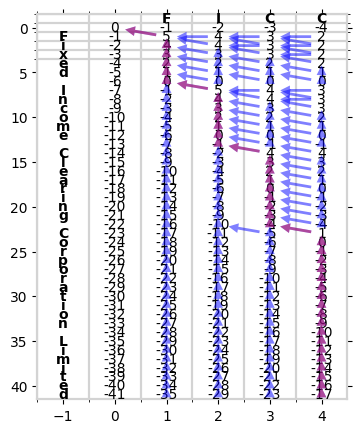

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
#from Bio.Seq import Seq
#------------------------------
seq1 = "FICC"
seq2 = "fixed income clearing corporation limited".title()

match_award = 5
mismatch_penalty = -1
gap_penalty = -1
arrows = None


def match_score(alpha, beta):
    if alpha == beta:
        return match_award
    else:
        return mismatch_penalty


def needleman_wunsch(seq1, seq2):
    m, n = len(seq2), len(seq1)  # length of two sequences
    #---------
    dt = np.dtype([('diagonal', np.str_, 1),('up', np.str_, 1), ('left', np.str_, 1)])
    """
    Pointer Matrix size: (m + 1) x (n + 1)
    Datatype: 3 tuple to save direction of the path
    
    For more info: https://docs.scipy.org/doc/numpy/user/basics.rec.html
    """
    pt_mat = np.zeros((m + 1, n + 1), dtype=dt)

    #---------
    score_matrix = np.zeros((m + 1, n + 1), dtype=int)      # the DP table
    # Calculate DynamicProgramming table
    for i in range(0, m + 1):
        score_matrix[i][0] = gap_penalty * i
        pt_mat[i][0]['up'] = 'U'
    for j in range(0, n + 1):
        score_matrix[0][j] = gap_penalty * j
        pt_mat[0][j]['left'] = 'L'
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            diagonal = score_matrix[i - 1][j - 1] + \
                match_score(seq2[i - 1], seq1[j - 1])
            up = score_matrix[i - 1][j] + gap_penalty
            left = score_matrix[i][j - 1] + gap_penalty
            max_pointer = max(diagonal, up, left)
            score_matrix[i][j] = max_pointer
            if (diagonal == max_pointer):
                pt_mat[i][j]['diagonal'] = 'D'
            if (up == max_pointer):
                pt_mat[i][j]['up'] = 'U'
            if (left == max_pointer):
                pt_mat[i][j]['left'] = 'L'

    # print(score_matrix)
    # print(pt_mat)

    # Traceback and compute the alignment
    align1, align2 = '', ''
    i, j = m, n  # start from the bottom right cell
    a = np.array([[0, 0, 0, 0]])

    first = True
    global arrows
    while i > 0 and j > 0:  # end toching the top or the left edge
        score_current = score_matrix[i][j]
        score_diagonal = score_matrix[i - 1][j - 1]
        score_up = score_matrix[i][j - 1]
        score_left = score_matrix[i - 1][j]
        #print("current ",i,j,end='')
        a[:, :2] = j, i
        if score_current == score_diagonal + match_score(seq2[i - 1], seq1[j - 1]):
            align1 += seq2[i - 1]
            align2 += seq1[j - 1]
            i -= 1
            j -= 1
        elif score_current == score_left + gap_penalty:
            align1 += seq2[i - 1]
            align2 += '-'
            i -= 1
        elif score_current == score_up + gap_penalty:
            align1 += '-'
            align2 += seq1[j - 1]
            j -= 1
        a[:, 2:] = j, i
        if first:
            # First loop copy a
            arrows = np.copy(a)
            first = False
        else:
            # Concatenate origin-target
            arrows = np.concatenate((arrows, a), axis=0)
    a[:, :2] = a[:, 2:]

    # Finish tracing up to the top left cell
    while i > 0:
        align1 += seq2[i - 1]
        align2 += '-'
        i -= 1
        a[:, 2:] = j, i
        arrows = np.concatenate((arrows, a), axis=0)
    while j > 0:
        align1 += '-'
        align2 += seq1[j - 1]
        j -= 1
        a[:, 2:] = j, i
        arrows = np.concatenate((arrows, a), axis=0)
    return score_matrix, pt_mat


#-------------------------------
plt.rcParams["figure.figsize"] = 4, 5
param = {"grid.linewidth": 1.6,
         "grid.color": "lightgray",
         "axes.linewidth": 1.6,
         "axes.edgecolor": "lightgray"}
plt.rcParams.update(param)

# Data
headh = seq1
headv = seq2

v, pt_mat = needleman_wunsch(seq1, seq2)

# Plot
fig, ax = plt.subplots()
ax.set_xlim(-1.5, v.shape[1] - .5)
ax.set_ylim(-1.5, v.shape[0] - .5)
ax.invert_yaxis()
for i in range(v.shape[0]):
    for j in range(v.shape[1]):
        ax.text(j, i, v[i, j], ha="center", va="center")
for i, l in enumerate(headh):
    ax.text(i + 1, -1, l, ha="center", va="center", fontweight="semibold")
for i, l in enumerate(headv):
    ax.text(-1, i + 1, l, ha="center", va="center", fontweight="semibold")

ax.xaxis.set_minor_locator(ticker.FixedLocator(
    np.arange(-1.5, v.shape[1] - .5, 1)))
ax.yaxis.set_minor_locator(ticker.FixedLocator(
    np.arange(-1.5, v.shape[1] - .5, 1)))
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                left="off", right="off", labelbottom='off', labelleft='off')
ax.grid(True, which='minor')


arrowprops = dict(facecolor='blue', alpha=0.5, lw=0,
                  shrink=0.2, width=2, headwidth=7, headlength=7)

# all paths
for i in range(1, pt_mat.shape[0]):
    for j in range(1, pt_mat.shape[1]):
        if(pt_mat[i][j]['left'] != ''):
            ax.annotate("", xy=(j - 1, i),
                        xytext=(j, i), arrowprops=arrowprops)
        if(pt_mat[i][j]['diagonal'] != ''):
            ax.annotate("", xy=(j - 1, i - 1),
                        xytext=(j, i), arrowprops=arrowprops)
        if(pt_mat[i][j]['up'] != ''):
            ax.annotate("", xy=(j, i - 1),
                        xytext=(j, i), arrowprops=arrowprops)

# optimal path
arrowprops.update(facecolor='crimson')
for i in range(arrows.shape[0]):
    ax.annotate("", xy=arrows[i, 2:],
                xytext=arrows[i, :2], arrowprops=arrowprops)
plt.show()

In [14]:
v

array([[  0,  -1,  -2],
       [ -1,   5,   4],
       [ -2,   4,   4],
       [ -3,   3,   3],
       [ -4,   2,   2],
       [ -5,   1,   1],
       [ -6,   0,   0],
       [ -7,  -1,  -1],
       [ -8,  -2,  -2],
       [ -9,  -3,  -3],
       [-10,  -4,  -4],
       [-11,  -5,  -5],
       [-12,  -6,  -6],
       [-13,  -7,  -7],
       [-14,  -8,  -8],
       [-15,  -9,  -9],
       [-16, -10, -10],
       [-17, -11, -11],
       [-18, -12, -12],
       [-19, -13, -13],
       [-20, -14,  -8],
       [-21, -15,  -9],
       [-22, -16, -10],
       [-23, -17, -11],
       [-24, -18, -12],
       [-25, -19, -13],
       [-26, -20, -14],
       [-27, -21, -15]])

In [15]:
pt_mat

array([[('', 'U', 'L'), ('', '', 'L'), ('', '', 'L')],
       [('', 'U', ''), ('D', '', ''), ('', '', 'L')],
       [('', 'U', ''), ('', 'U', ''), ('D', '', '')],
       [('', 'U', ''), ('', 'U', ''), ('D', 'U', '')],
       [('', 'U', ''), ('', 'U', ''), ('D', 'U', '')],
       [('', 'U', ''), ('', 'U', ''), ('D', 'U', '')],
       [('', 'U', ''), ('D', 'U', ''), ('D', 'U', '')],
       [('', 'U', ''), ('', 'U', ''), ('D', 'U', '')],
       [('', 'U', ''), ('', 'U', ''), ('D', 'U', '')],
       [('', 'U', ''), ('', 'U', ''), ('D', 'U', '')],
       [('', 'U', ''), ('', 'U', ''), ('D', 'U', '')],
       [('', 'U', ''), ('', 'U', ''), ('D', 'U', '')],
       [('', 'U', ''), ('', 'U', ''), ('D', 'U', '')],
       [('', 'U', ''), ('', 'U', ''), ('D', 'U', '')],
       [('', 'U', ''), ('', 'U', ''), ('D', 'U', '')],
       [('', 'U', ''), ('', 'U', ''), ('D', 'U', '')],
       [('', 'U', ''), ('', 'U', ''), ('D', 'U', '')],
       [('', 'U', ''), ('', 'U', ''), ('D', 'U', '')],
       [(''

In [85]:
penalty = {'MATCH': 10, 'MISMATCH': -1, 'GAP': 0}
arrows = np.array([[0, 0, 0, 0]])


def match_score(alpha, beta):
    if alpha == beta:
        return penalty['MATCH']
    else:
        return penalty['MISMATCH']


def finalize(align1, align2, score):
    align1 = align1[::-1]  # reverse sequence 1
    align2 = align2[::-1]  # reverse sequence 2

    i, j = 0, 0

    # calcuate identity, score and aligned sequeces
    symbol = ''
    found = 0
    for i in range(0, len(align1)):
        # if two AAs are the same, then output the letter
        if align1[i] == align2[i]:
            symbol += '|'

        # if they are not identical and none of them is gap
        elif align1[i] != align2[i] and align1[i] != '-' and align2[i] != '-':
            symbol += ' '
            found = 0

        # if one of them is a gap, output a space
        elif align1[i] == '-' or align2[i] == '-':
            symbol += ' '

    print ('Score =', score)
    print (align1)
    print (symbol)
    print (align2)


def needleman_wunsch(seq_alpha_col, seq_beta_row, p_penalty, score_only):
    """
    Llena las matrices de acuerdo al algoritmo Needleman-Wunsch.

    Esta función realiza las operaciones necesarias para lograr el 
    alineamiento global (Needleman-Wunsch) entre dos secuencias. 
    Un alineamiento global encuentra la mejor concordancia entre 
    todos los caracteres de las dos secuencias.

    Al realizar alineamientos, se puede especificar el match score,
    el mismath score y el gap penalty. El match score indica la compatibilidad 
    entre un alineamiento entre dos caracteres en las secuencias.
    Los caracteres altamente compatibles deben recibir la puntuación del match, 
    y los que no sean compatibles deben recibir la puntuación de mismatch. 
    Los gaps deben ser negativos.

    Parameters
    ----------
    seq_alpha_col : Bio.Seq.Seq
        Primer secuencia a ser comparada
    
    seq_beta_row : Bio.Seq.Seq
        Segunda secuencia a ser comparada
    
    p_penalty : dict(str -> int)
        Diccionario que contiene los valores de MATCH, MISMATCH y GAP

    score_only : boolean
        Cuando es True solamente muestra el alineamiento y el valor del score, 
        así se utiliza menos memoria y es más rápido.
        Cuando es False guarda la matriz y la traza que recorre el alineamiento
        en la carpeta `/output`.

    Returns
    -------
    np.array, np.array, np.array
        Tres arreglos que contienen los puntajes, los punteros y la matriz del mejor alineamiento

    """
    if not seq_alpha_col or not seq_beta_row:
        print("Alguna de las secuencias está vacía.")
        return
    global penalty
    penalty = p_penalty
    m, n = len(seq_beta_row), len(seq_alpha_col)  # length of two sequences
    #---------
    pointer_mat = []  # pointer matrix

    if not score_only:
        # Custom datatype 3-tuple for ('D','U','L')
        dt = np.dtype([('diagonal', np.str, 1),
                       ('up', np.str, 1), ('left', np.str, 1)])

        pointer_mat = np.zeros((m + 1, n + 1), dtype=dt)

    #---------
    score_matrix = np.zeros((m + 1, n + 1), dtype=int)      # the DP table
    # Calculate DP table
    for i in range(0, m + 1):
        score_matrix[i][0] = penalty['GAP'] * i
        if not score_only:
            pointer_mat[i][0]['up'] = 'U'
    for j in range(0, n + 1):
        score_matrix[0][j] = penalty['GAP'] * j
        if not score_only:
            pointer_mat[0][j]['left'] = 'L'
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            diagonal = score_matrix[i - 1][j - 1] + \
                match_score(seq_beta_row[i - 1], seq_alpha_col[j - 1])
            up = score_matrix[i - 1][j] + penalty['GAP']
            left = score_matrix[i][j - 1] + penalty['GAP']
            max_pointer = max(diagonal, up, left)
            score_matrix[i][j] = max_pointer
            if not score_only:
                if (diagonal == max_pointer):
                    pointer_mat[i][j]['diagonal'] = 'D'
                if (up == max_pointer):
                    pointer_mat[i][j]['up'] = 'U'
                if (left == max_pointer):
                    pointer_mat[i][j]['left'] = 'L'
    #if score_only:
        #print(score_matrix)
    # print(pt_mat)

    # Traceback and compute the alignment
    align1, align2 = '', ''
    i, j = m, n  # start from the bottom right cell
    a = np.array([[0, 0, 0, 0]])

    first = True
    global arrows
    score = score_matrix[i][j]
    while i > 0 and j > 0:  # end toching the top or the left edge
        score_current = score_matrix[i][j]
        score_diagonal = score_matrix[i - 1][j - 1]
        score_up = score_matrix[i][j - 1]
        score_left = score_matrix[i - 1][j]
        if not score_only:
            a[:, :2] = j, i

        match_score_val = match_score(
            seq_beta_row[i - 1], seq_alpha_col[j - 1])

        if score_current == score_diagonal + match_score_val:
            align1 += seq_beta_row[i - 1]
            align2 += seq_alpha_col[j - 1]
            i -= 1
            j -= 1
            score = score + match_score_val
        elif score_current == score_left + penalty['GAP']:
            align1 += seq_beta_row[i - 1]
            align2 += '-'
            i -= 1
            score = score + penalty['GAP']
        elif score_current == score_up + penalty['GAP']:
            align1 += '-'
            align2 += seq_alpha_col[j - 1]
            j -= 1
            score = score + penalty['GAP']
        if not score_only:
            a[:, 2:] = j, i
            if first:
                arrows = np.copy(a)
                first = False
            else:
                arrows = np.concatenate((arrows, a), axis=0)
    if not score_only:
        a[:, :2] = a[:, 2:]
    # print(arrows)
    # print(a)

    # Finish tracing up to the top left cell
    while i > 0:
        align1 += seq_beta_row[i - 1]
        align2 += '-'
        i -= 1
        if not score_only:
            a[:, 2:] = j, i
            arrows = np.concatenate((arrows, a), axis=0)
    while j > 0:
        align1 += '-'
        align2 += seq_alpha_col[j - 1]
        j -= 1
        if not score_only:
            a[:, 2:] = j, i
            arrows = np.concatenate((arrows, a), axis=0)

    finalize(align1, align2, score)
    return score_matrix, pointer_mat, arrows


In [91]:
alpha = "NASA"
beta = "National Aeronautics and Space Administration".title()
value = needleman_wunsch(alpha, beta, penalty, score_only=True)

Score = 80
National Aeronautics And Space Administration
|                    |   |     |             
N--------------------A---S-----A-------------
